# Examen segundo parcial. Optimización
Guillermo Segura Gómez

## Ejercicio 1.

Considere el problema 

$$ \min\; f(\mathbf{x}) \quad \text{sujeto a} \quad c_1(\mathbf{x})=0.$$

Encontrar la solución usando un penalización cuadrática (clase 29). 
Para esto contruimos la función

$$
Q(\mathbf{x}; \mu) =  f(\mathbf{x}) + \frac{\mu}{2 }(c_1(\mathbf{x}) )^2
$$

1. Programar la función $Q(x; \mu)$ y su gradiente 

$$\nabla Q(\mathbf{x}; \mu) = \nabla f(\mathbf{x}) + \mu c_1(\mathbf{x}) \nabla c_1(\mathbf{x}).$$


In [31]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt

In [82]:
# Función Q(x, mu)
def Q(f, c1, x, mu):
    return f(x) + 0.5 * mu * c1(x)**2

# Gradiente de Q
def gradQ(gradf, c1, gradc1, x, mu):
    return gradf(x) + mu * c1(x) * gradc1(x)

# Aproximación de la Hessiana de Q como la matriz identidad
def hessian_identidad(x):
    return np.eye(len(x))

2. Programar el método de penalización cuadrática usando el método BFGS modificado:

In [83]:
# Funcion de Backtracking
def Backtracking_DescSuf(alpha_0, rho, c1, xk, fk, gk, pk, nMax):

    for i in range(nMax):

        comp1 = fk(xk + alpha_0*pk)
        comp2 = fk(xk) + c1*alpha_0* np.dot(gk, pk)

        if (comp1 <= comp2):
            return alpha_0, i

        alpha_0 = alpha_0*rho

    return alpha_0, i

# Método de Broyden, FLetcher, Goldfarb y Shannon
def BFGS_mod(f, gradf, x0, tau, HessAprox, nMax, alpha_0, rho, c1, nBack):
    
    # Valores iniciales
    dim = len(x0)
    xk = np.array(x0)
    sequence = []

    # Inicializamos gk y Hk
    gk = gradf(xk)
    Hk = HessAprox(xk)
    
    for k in range(nMax):

        # Convergencia
        if np.linalg.norm(gk) < tau:
            return xk, k, gk, True, sequence

        # Calculamos la direccion pk = -Hk * gk
        pk = np.dot(-Hk, gk)

        # Condición de parada
        if pk @ gk > 0:
            
            # Calculamos lambda
            lambda1 = (10**-5) + (pk.T @ gk) / (gk.T @ gk)

            # Actualizamos Hk
            Hk = Hk + lambda1 * np.eye(dim)

            # Redefinimos p
            # pk = -lambda1 * gk
            pk = np.dot(-Hk, gk)

        # Calculamos el tamaño de paso
        alphak, _ = Backtracking_DescSuf(alpha_0, rho, c1, xk, f, gk, pk, nBack)

        # Calculamos los valores siguientes
        xk_next = xk + alphak * pk
        sk = xk_next - xk
        yk = gradf(xk_next) - gk

        # Calculamos Hk_next
        if (yk.T @ sk) <= 0:

            if np.dot(yk, yk) > 1e-10:  # Asegura que el denominador es suficientemente grande
                # Calculamos lambda
                lambda2 = 10**-5 - (yk.T @ sk) / (yk.T @ yk)
            else:
                lambda2 = 10**-5

            Hk_next = Hk + lambda2 * np.eye(dim)

        else:
            rhok = 1 / (yk.T @ sk) # Calculamos rho_k
            I = np.eye(dim)
            Hk_next = (I - rhok * np.outer(sk, yk)) @ Hk @ (I - rhok * np.outer(yk, sk)) + rhok * np.outer(sk, sk)

        # Actualizamos los valores
        xk = xk_next
        Hk = Hk_next
        gk = gradf(xk)

        # Almacenar puntos solo para visualización en 2D
        if len(x0) == 2:
            sequence.append(xk.tolist())

    return xk, nMax, gk, False, sequence

Programamos el método de penalización cuadrática.

a) Dar la función $f(\mathbf{x})$, $c_1(\mathbf{x})$, la función $Q(\mathbf{x}; \mu)$, su gradiente $\nabla Q(\mathbf{x}; \mu)$, 
   un punto inicial $\mathbf{x}_0$,  $\mu_0$, una
   tolerancia $\tau>0$, el número máximo de iteraciones $N$, y los parámetros que se necesiten para usar el método BFGS modificado.

b) Para $k=0, 1, ..., N$ repetir los siguientes pasos:

b1) Definir $\tau_k = \left(1 + \frac{10N}{10k+1} \right)\tau$

b2) Calcular el punto  $\mathbf{x}_{k+1}$ como el minimizador de $Q(\mathbf{x}; \mu_k)$ 
    con el método BFGS modificado usando como punto inicial a $\mathbf{x}_{k}$ y la tolerancia $\tau_k$.

b3) Imprimir el punto $\mathbf{x}_{k+1}$, $f(\mathbf{x}_{k+1})$, $Q(\mathbf{x}; \mu_k)$,
    el número de iteraciones realizó el algoritmo BFGS
    y el valor  $c_1(\mathbf{x}_{k+1})$.

b4) Si $\|\mathbf{x}_{k+1} - \mathbf{x}_k\|<\tau$, terminar devolviendo  $\mathbf{x}_{k+1}$ 

b5) En caso contrario, hacer $\mu_{k+1} = 2\mu_k$ y volver al paso (b1)

In [89]:
def Penalizacion2(f, gradf, mu, c1, gradc1, Q, gradQ, hessQ, x0, tau, nMax, alpha_0, rho, c1_, nBack):

    # Valores iniciales
    xk = np.array(x0)
    sequence = []

    for k in range(nMax):

        # Definimos tk
        tk = 1.0 + (10.0 * nMax) / (10.0 * (k + 1))

        # Funciones temporales
        Q_temp = lambda x: Q(f, c1, x, mu)
        gradQ_temp = lambda x: gradQ(gradf, c1, gradc1, x, mu)

        # Minimizar Q(x, tk) con el método de BFGS
        xk_next, iteraBFGS, _, convBFGS, _ = BFGS_mod(Q_temp, gradQ_temp, xk, tau, hessQ, nMax, alpha_0, rho, c1_, nBack)

        # Imprimimos valores singulares
        # print(f"Valor xk_next: {xk_next}")
        # print(f"Valor f(x_next): {f(xk_next)}")
        # print(f"Valor Q(x_next): {Q(f, c1, xk_next, mu)}")
        # print(f"Numero de iteraciones BFGS: {iteraBFGS}, convergencia BFGS: {convBFGS}")
        # print(f"Valor c1(x_next): {c1(xk_next)}")

        # Revisamos convergencia
        if np.linalg.norm(xk_next - xk) < tau:
            return xk, k, True, sequence

        # Actualizamos valores
        mu *= 2
        xk = xk_next

        # Almacenar puntos solo para visualización en 2D
        if len(x0) == 2:
            sequence.append(xk.tolist())

    return xk, nMax, False, sequence

3. Probar el algoritmo tomando como $f$ a la función de Beale, $c_1(\mathbf{x}) = x_1^2 + x_2^2 - 4$, 
   $\mu_0=0.5$, $N=1000$ y $\tau=\epsilon_m^{1/3}$.
   
   Use los puntos iniciales $\mathbf{x}_0 = (0, 2)$ y $\mathbf{x}_0 = (0, -2)$.

In [90]:
def beale(x):
    return ((1.5 - x[0] + x[0]*x[1])**2 + 
            (2.25 - x[0] + x[0]*x[1]**2)**2 + 
            (2.625 - x[0] + x[0]*x[1]**3)**2)

def grad_beale(x):
    x1, x2 = x
    df_dx1 = 2*(1.5 - x1 + x1*x2)*(-1 + x2) + 2*(2.25 - x1 + x1*x2**2)*(-1 + x2**2) + 2*(2.625 - x1 + x1*x2**3)*(-1 + x2**3)
    df_dx2 = 2*(1.5 - x1 + x1*x2)*x1 + 2*(2.25 - x1 + x1*x2**2)*2*x1*x2 + 2*(2.625 - x1 + x1*x2**3)*3*x1*x2**2
    return np.array([df_dx1, df_dx2])

def c1(x):
    return x[0]**2 + x[1]**2 - 4

def gradc1(x):
    return np.array([2*x[0], 2*x[1]])

In [91]:
# Función para visualizar los contornos de nivel de función en 2D
def contornosFnc2D(fncf, xleft, xright, ybottom, ytop, levels, secuencia=None):
    ax = np.linspace(xleft, xright, 250)
    ay = np.linspace(ybottom, ytop, 200)
    mX, mY = np.meshgrid(ax, ay)
    mZ = np.array([[fncf(np.array([x, y])) for x in ax] for y in ay])

    fig, ax = plt.subplots()
    CS = ax.contour(mX, mY, mZ, levels, cmap='viridis')
    plt.colorbar(CS, ax=ax)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    # Graficar la secuencia de puntos
    if secuencia is not None:
        secuencia = np.array(secuencia)
        ax.plot(secuencia[:, 0], secuencia[:, 1], 'r.-')  # 'r.-' para puntos rojos conectados por líneas
        ax.plot(secuencia[0, 0], secuencia[0, 1], 'go')  # Punto de inicio en verde
        ax.plot(secuencia[-1, 0], secuencia[-1, 1], 'bo')  # Punto final en azul

    plt.show()

Función de Beale:
Resultado para x0 = [0. 2.], f(x0) = 14.203125:
Punto final xk = [-1.34645015  1.47888025], Iteraciones k = 16, f(xk) = 1.3031497858429537, convergió: True


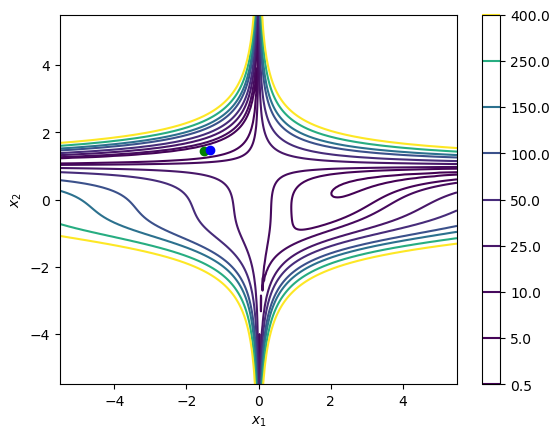


Resultado para x0 = [ 0. -2.], f(x0) = 14.203125:
Punto final xk = [1.99369313 0.15878224], Iteraciones k = 16, f(xk) = 0.5340502689501687, convergió: True


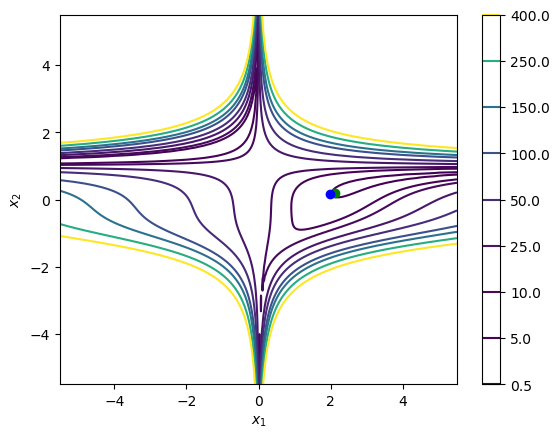

In [92]:
# Puntos iniciales para la función de Beale
puntos_iniciales_beale = [np.array([0.0, 2.0]), np.array([0.0, -2.0])]

# Epsilon de la máquina
epsilon_m = np.finfo(float).eps

# Configuración de tolerancia
tau = epsilon_m**(1/3)

# Parámetros iniciales
alpha_0 = 1
rho = 0.5
c1_ = 0.001

# Número máximo de iteraciones para el descenso máximo y la sección dorada
NMax = 1000
NBack = 500

# Función para probar el algoritmo de newton con diferentes funciones
def probar_algoritmo(func, grad_func, hess_func, c1, gradc1, mu, puntos_iniciales):
    for x0 in puntos_iniciales:
        xk, k, convergio, secuencia = Penalizacion2(func, grad_func, mu, c1, gradc1, Q, gradQ, hess_func, x0, tau, NMax, alpha_0, rho, c1_, NBack)
        valor_final = func(xk)
        print(f"Resultado para x0 = {x0}, f(x0) = {func(x0)}:")
        print(f"Punto final xk = {xk}, Iteraciones k = {k}, f(xk) = {valor_final}, convergió: {convergio}")
        if len(x0) == 2 and secuencia:
            contornosFnc2D(func, xleft=-5.5, xright=5.5, ybottom=-5.5, ytop=5.5, levels=[0.5, 5, 10, 25, 50, 100, 150, 250, 400], secuencia=secuencia)
        print()


# Probar con la función de Beale
print("Función de Beale:")
probar_algoritmo(beale, grad_beale, hessian_identidad, c1, gradc1, 0.5, puntos_iniciales_beale)


4. Para verificar el resultado obtenido  haga lo siguiente:

- Genere una partición $\theta_0 < \theta_1 < ... \theta_m$ del intervalo $[0, 2\pi]$ con $m=1000$
- Evalue la función de Beale en los puntos $(2\cos \theta_i, 2\sin \theta_i)$ para $i=0, 1, ..., m$.  
  e imprima el punto en donde la función tuvo el menor valor y el valor de la función
  en ese punto.
   
   
**Nota:** Si no tiene implementado el método BFGS modificado, puede elegir otro método de optimización,
pero se aplica una penalización de 0.5 puntos.

In [94]:
# Genera la partición del intervalo [0, 2π] con m=1000
m = 1000
theta = np.linspace(0, 2*np.pi, m)

# Evaluar la función de Beale en los puntos (2*cos(theta_i), 2*sin(theta_i))
points = [(2*np.cos(t), 2*np.sin(t)) for t in theta]
values = [beale(point) for point in points]

# Encontrar el mínimo valor y su correspondiente punto
min_value = min(values)
min_index = values.index(min_value)
min_point = points[min_index]

# Imprimir el punto y el valor mínimo
print(f"Punto donde la función tuvo el menor valor: {min_point}")
print(f"Valor de la función en ese punto: {min_value}")

Punto donde la función tuvo el menor valor: (1.9933185071907058, 0.16334420372641326)
Valor de la función en ese punto: 0.5342196283845664


## Ejercicio 2

Programar el método de Newton para resolver el sistema de ecuaciones no lineales
(Algoritmo 1 de la Clase 24):

$$ \begin{array}{rcl}
 2x_0 + x_1 &=& 5 - 2x_2^2 \\
    x_1^3 + 4x_2 &=& 4 \\
    x_0 x_1 + x_2 &=& \exp(x_2)
   \end{array}
$$

1. Programar la función $\mathbf{F}(\mathbf{x})$ correspondiente a este sistema de ecuaciones y 
   su Jacobiana $\mathbf{J}(\mathbf{x})$ 

In [107]:
# Función F
def F(x):
    return np.array([
        2*x[0] + x[1] - 5 + 2*x[2]**2,
        x[1]**3 + 4*x[2] - 4,
        x[0]*x[1] + x[2] - np.exp(x[2])
    ])

# Jacobiano de F
def J(x):
    # Derivadas parciales de F
    return np.array([
        [2, 1, 4*x[2]],
        [0, 3*x[1]**2, 4],
        [x[1], x[0], 1 - np.exp(x[2])]
    ])

2. Programe el algoritmo del método de Newton. Use como condición de paro que el ciclo termine
   cuando $\|\mathbf{F}(\mathbf{x}_k)\|< \tau$, para una tolerancia $\tau$ dada.
   Haga que el algoritmo devuelva el punto $\mathbf{x}_k$, el número de iteraciones $k$,
   el valor $\|\mathbf{F}(\mathbf{x}_k)\|$ y una variable indicadora $bres$ que es $1$
   si se cumplió el criterio de paro o $0$ si terminó por iteraciones.

In [108]:
# Metodo de Newton para sistemas no lineales
def NewtonNLineal(f, jacf, x0, tau, nMax):

    # Valores iniciales
    xk = np.array(x0)
    
    for k in range(nMax):
        Fk = f(xk)
        
        # Convergencia
        if np.linalg.norm(Fk) < tau:
            return xk, k, np.linalg.norm(Fk), True
        
        # Calculamos el jacobiano
        Jk = jacf(xk)
        
        # Resolvemos el sistema Jk * sk = -Fk
        sk = np.linalg.solve(Jk, -Fk)
        
        # Calculamos el punto siguiente
        xk = xk + sk
        
    return xk, nMax, np.linalg.norm(Fk), False

3. Para probar el algoritmo y tratar de encontrar varias raíces, 
   haga un ciclo para hacer 20 iteraciones y en cada iteración haga lo siguiente:
   
- Dé el punto inicial $\mathbf{x}_0$ como un punto aleatorio generado con `numpy.random.randn(3)`
- Ejecute el método de Newton usando $\mathbf{x}_0$, la tolerancia $\tau = \sqrt{\epsilon_m}$ y 
  un máximo de iteraciones $N=100$.
- Imprima el punto $\mathbf{x}_k$ que devuelve el algoritmo, la cantidad
  de iteraciones realizadas, el valor de $\|\mathbf{F}(\mathbf{x}_k)\|$ y la variable
  indicadora $bres$.


In [109]:
# Probar el algoritmo
N = 100

# Ejecutar varias veces con diferentes puntos iniciales
for i in range(20):
    x0 = np.random.randn(3)
    xk, k, normFk, convergencia = NewtonNLineal(F, J, x0, tau, N)
    print(f"Iteración {i+1}: xk = {xk}, Iteraciones = {k}, Norma de F(xk) = {normFk}, Convergió = {convergencia}")

Iteración 1: xk = [ 0.66819062  1.97278644 -0.91946515], Iteraciones = 11, Norma de F(xk) = 4.770725885797244e-09, Convergió = True
Iteración 2: xk = [1.42246939 0.97538853 0.76800804], Iteraciones = 7, Norma de F(xk) = 5.751757970511126e-09, Convergió = True
Iteración 3: xk = [ 0.66819062  1.97278644 -0.91946515], Iteraciones = 13, Norma de F(xk) = 5.924168602966591e-13, Convergió = True
Iteración 4: xk = [1.42246939 0.97538853 0.76800804], Iteraciones = 6, Norma de F(xk) = 5.841081590836475e-14, Convergió = True
Iteración 5: xk = [1.42246939 0.97538853 0.76800804], Iteraciones = 11, Norma de F(xk) = 1.7643759876244597e-13, Convergió = True
Iteración 6: xk = [ 0.66819062  1.97278644 -0.91946515], Iteraciones = 9, Norma de F(xk) = 1.1022797456473694e-12, Convergió = True
Iteración 7: xk = [1.42246939 0.97538853 0.76800804], Iteraciones = 18, Norma de F(xk) = 2.1765279274386676e-12, Convergió = True
Iteración 8: xk = [ 0.66819062  1.97278644 -0.91946515], Iteraciones = 21, Norma de F(xk